- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2020/2021
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 2. Diseño de DSS en Industria 4.0 (Parte 2/3)

Continuamos profundizando en el desarrollo de modelos predictivos que puedan ser usados en una planta de galvanizado de bobinas de acero. El objetivo de esta segunda parte consiste en desarrollar modelos que 'aprendan' a determinar la temperatura a la que hay que poner el horno de galvanizado según las dimensiones de la bobina de acero y otras variables objetivo como puede ser la temperatura a la que debe salir la banda de acero (TMPP2CNG) y la velocidad media (VELMED).

Como queremos el modelo del CASO A de predicción de temperaturas de consigna del horno sea suficientemente preciso y eficiente, necesitaremos extraer de la base de datos aquellas observaciones cuya temperatura de salida (TMPP2) frente a la objetivo (TMPP2CNG) tenga una diferencia máxima de 25ºC en valor absoluto. Es decir, vamos a desarrollar unos modelos que “aprendan” de aquellos casos donde las consignas del horno han sido correctas cuando el tratamiento se ha realizado correctamente. En este caso, el modelo aprenderá de los casos donde la bobina ha sido procesada correctamente, tanto en el 'modo manual' como en el 'automático'.

In [1]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

In [2]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


## Cargamos la Base de Datos y Eliminamos los Casos Anómalos

In [3]:
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff -O DATOS_HORNO_ENTRENA.arff
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_TESTEO.arff -O DATOS_HORNO_TESTEO.arff

--2021-04-30 16:55:44--  https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff [following]
--2021-04-30 16:55:44--  https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125832 (123K) [text/plain]
Saving to: ‘DATOS_HORNO_ENTRENA.arff’

DATOS_HORNO_ENTRENA 100%[===================>] 122.88K  --.-KB/s    in 0.03s   

2021-04-30 16:55:45 (4.59 MB/s) - ‘DATOS_HORNO_ENTRENA.arff’ saved [125832/125832]

--2021-04-30

In [4]:
# Leemos los archivos arff
df_train = pd.DataFrame(arff.loadarff("DATOS_HORNO_ENTRENA.arff")[0])
df_test = pd.DataFrame(arff.loadarff("DATOS_HORNO_TESTEO.arff")[0])

In [5]:
df_train['CLASACERO'] = df_train['CLASACERO'].str.decode('utf-8')
df_test['CLASACERO'] = df_test['CLASACERO'].str.decode('utf-8')

df_train['CODBOB'] = df_train['CODBOB'].astype(int)
df_test['CODBOB'] = df_test['CODBOB'].astype(int)

display(df_train.head(3), df_test.head(3))

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0


,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0


In [6]:
df_train = df_train.loc[df_train['VELMED']<500] # Nos quedamos con los casos menores de 500

## Creación del Modelo A. Modelo para predecir la temperatura en la zona 1 del horno (THC1)

Lo primero que vamos a hacer es eliminar los casos donde la diferencia en valor absoluto entre la temperatura de consigna (TMPP2CNG) y la temperatura real (TMPP2) sea mayor de 25 grados centígrados. El objetivo es eliminar de la base de datos las bobinas que no han sido tratadas correctamente.

In [7]:
print(df_train.shape, df_test.shape)

(1894, 13) (81, 13)


In [8]:
df_train_limpia = df_train.loc[np.abs(df_train['TMPP2CNG']-df_train['TMPP2'])<=25].copy()
print(df_train_limpia.shape)

(1851, 13)


In [9]:
df_train_limpia.head(2)

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0


Tenemos una clase categórica (CLASACERO). Aunque existen algoritmos de machine learning que pueden trabajar con ella directamente. Nosotros vamos a crear variables binarias 'dummy features' mediante 'hot encoding'.

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df_dummies = pd.get_dummies(df_train_limpia['CLASACERO'].append(df_test['CLASACERO']))
df_train_limpia_cat = df_train_limpia.join(df_dummies.iloc[:len(df_train_limpia)])
df_test_cat = df_test.join(df_dummies.iloc[len(df_train_limpia):])
df_train_limpia_cat.iloc[:,-10:].head()

,D094B33,D094G55,K011B55,K011F57,K021H43,K021H53,K022H53,N013H53,N017B97,X100G99
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


### Entrenamiento del Modelo con Validación Cruzada con Repetición

Para crear un modelo que permita determinar el valor de temperatura en la zona 1 del horno, es muy importante tomar en cuenta **cuáles son las variables de las que vamos a disponer realmente en el momento de uso del modelo**. Por ejemplo, las variables TMPP1 y TMPP2 son variables que corresponden a la temperatura de la bobina a la entrada y salida del horno, y que son medidas por pirómetros. Estas variables no pueden ser utilizadas en el momento del entrenamiento del modelo pues se pretende crear un modelo para predecir las consignas del horno antes de procesar las bobinas. Otra variable como VELMED, que corresponde con la velocidad de la banda de acero, si puede ser considerada pues va a ser una consigna preestablecida.

In [11]:
# Como la base de datos es muy pequeña, es importante realizar una validación cruzada repetida varias veces
# Las métricas calculadas tendrán una varianza menor y las estimaciones serán más realistas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold

In [12]:
# Función que obtiene el MAE, RMSE y R2 de VC con repetición y para la base de datos de testeo
def entrena_model(model, num_folds=5, num_bags=10): #num_folds trozos en los que te divide el entrenamiento 
    np.random.seed(2020)
    X_tot = df_train_esc.copy()
    y_tot = df_train_limpia[target].values.reshape(-1)
    X_test = df_test_esc.copy()
    y_test = df_test[target].values.reshape(-1)
    
    # Creamos arrays para las predicciones
    preds_val = np.empty((len(X_tot),num_bags)) 
    preds_val[:] = np.nan
    preds_test = np.empty((len(X_test),num_bags*num_folds))
    preds_test[:] = np.nan
    # Entrena y extrae la predicciones con validación cruzada repetida
    
    folds = RepeatedKFold(n_splits=num_folds, n_repeats=num_bags, random_state=2020)  
    for niter, (train_index, val_index) in enumerate(folds.split(X_tot, y_tot)):
        nbag = niter//num_folds #Extrae el número de repetición (bag)
        X_train, X_val = X_tot[train_index], X_tot[val_index]
        y_train, y_val = y_tot[train_index], y_tot[val_index]
        model.fit(X_train, y_train)
        preds_val[val_index,nbag] = model.predict(X_val)
        preds_test[:,niter] = model.predict(X_test)
        
    # Promedia las predicciones
    preds_val_mean = preds_val.mean(axis=1) 
    preds_test_mean = preds_test.mean(axis=1)
    
    # Extrae las métricas
    mae_val = mean_absolute_error(y_tot, preds_val_mean) 
    rmse_val = np.sqrt(mean_squared_error(y_tot, preds_val_mean))
    r2_val = r2_score(y_tot, preds_val_mean)
    
    mae_tst = mean_absolute_error(y_test, preds_test_mean) 
    rmse_tst = np.sqrt(mean_squared_error(y_test, preds_test_mean))
    r2_tst = r2_score(y_test, preds_test_mean)
    
    return mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_tot, preds_val_mean, y_test, preds_test_mean, preds_val, preds_test

**EJERCICIO: Explica lo que hace la función 'entrena_modelo()'. Utiliza todas las celdas que consideres necesarias**

Entrada:

*   model: es el modelo elegido.
*   num_folds: pliegues en los que vamos a dividir el modelo.
*   num_bags: es el numero de veces que vamos a ejecutar la validacion cruzada.
  
Dentro de la función:


*   Separa los labels del dataframe del resto tanto en train como en test.
*   Arrays de predicciones: para los  de validacion crea un array donde reserva memoria pero no asigna ningun valor, y luego les asigna nan, lo mismo para test, solo que el tamaño de test es mucho mas grande.
*   En folds carga el numero de repeticiones y el numero de pliegues (trozos en los que se ha dividido el modelo)
*   En el for se entrena y se hace la validacion cruzada
*   Se sacan las medias de los resultados obtenidos
*   se extraen por ultimo los errores












 
  


Vamos a estandarizar la base de datos con *Z-Score*.

Seleccionamos las variables que por lógica deberían tener más influencia en THC1

Sin embargo, la utilización de otras características o la creación de otras nuevas, podrían ayudar y mejorar los resultados.

In [13]:
from sklearn.preprocessing import StandardScaler
# Variables seleccionadas para la creación del modelo THC1
selec_features = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP2CNG'] + list(df_dummies.columns)
target = ['THC1']

# Estandarizamos las bases de datos de entrenamiento y testeo
scaler = StandardScaler()
scaler.fit(df_train_limpia_cat[selec_features].values)
df_train_esc = scaler.transform(df_train_limpia_cat[selec_features].values)
df_test_esc = scaler.transform(df_test_cat[selec_features].values)
print(df_train_esc.shape)

(1851, 50)


## Modelo Ridge Linear Regresion

In [14]:
from sklearn.linear_model import Ridge
# Probamos con diferentes potencias de 10
for alpha in np.power(10.0,np.arange(-2,3,0.3)):
    model = Ridge(alpha=alpha)
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model)
    print('RIDGE con alpha={:.1e} ->\
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(alpha, 
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))
    

RIDGE con alpha=1.0e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.489,RMSE=7.912,R2=0.719]
RIDGE con alpha=2.0e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.489,RMSE=7.911,R2=0.719]
RIDGE con alpha=4.0e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.489,RMSE=7.911,R2=0.719]
RIDGE con alpha=7.9e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.488,RMSE=7.910,R2=0.719]
RIDGE con alpha=1.6e-01 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.486,RMSE=7.909,R2=0.719]
RIDGE con alpha=3.2e-01 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.484,RMSE=7.906,R2=0.719]
RIDGE con alpha=6.3e-01 ->    Val:[MAE=7.326,RMSE=10.120,R2=0.928]     Test:[MAE=6.479,RMSE=7.901,R2=0.720]
RIDGE con alpha=1.3e+00 ->    Val:[MAE=7.327,RMSE=10.120,R2=0.928]     Test:[MAE=6.471,RMSE=7.890,R2=0.720]
RIDGE con alpha=2.5e+00 ->    Val:[MAE=7.329,RMSE=10.121,R2=0.928]     Test:[MAE=6.455,RMSE=7.869,R2=0.722]
RIDGE con alpha=5.0e+00 ->  

Analizando los resultados y, según la métrica seleccionada, elegimos el modelo que menor error de validación tiene. 

En este caso, podemos ver que el modelo con *alpha=1.0e-02* **es el que tiene el menor RMSE de validación cruzada con repetición**. 

Podemos vernos tentados a seleccionar el modelo con *alpha=7.9e+01*, que es el que obtiene el mejor RMSE con la base de datos de testeo. Esto sería un error pues es una base de datos muy pequeña y podemos haber elegido un modelo sobreajustado. La base de datos de testeo se usa para ver si el modelo selecionado generaliza correctamente. 

Habitualmente, los errores de testeo deben ser parecidos a los de validación con unas diferencias entre ellos que sean asumibles. El error de validación cruzada es más robusto pues ha sido generado con muchas más muestras y con diversas repeticiones, por lo tanto, el modelo seleccionado debería trabajar mejor si las condiciones del proceso no cambian.

### Analisis de los Errores del Modelo

In [15]:
def dibuja_preds(y_true, y_pred, mae, rmse, r2tst, titulo='Real vs Prediccion'):
    titulo = titulo+'MAE:{:.3f}, RMSE:{:,.3f}, R2:{:,.3f}'.format(mae, rmse, r2tst)
    plt.figure(figsize=(8,8))
    # Diagonal
    min_x, max_x = y_true.min(), y_true.max()
    min_y, max_y = y_pred.min(), y_pred.max()
    # Preds vs Real
    min_tot = min(min_x,min_y)
    max_tot = max(max_x,max_y)
    plt.scatter(y_true,y_pred,alpha=0.80)
    plt.plot([min_tot, max_tot],[min_tot, max_tot], color='red')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.title(titulo)
    plt.show()

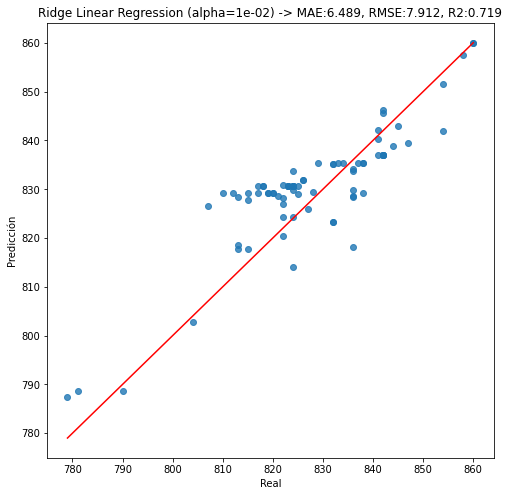

In [16]:
model = Ridge(alpha=1e-02)
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test, preds_test, val_mat, tst_mat = entrena_model(model)
dibuja_preds(y_test, preds_test, mae_tst, rmse_tst, r2_tst, 'Ridge Linear Regression (alpha=1e-02) -> ')

Vamos a visualizar la distribución de los errrores de validación cruzada

In [17]:
def saca_predicciones(y_true, y_pred):
    errores = y_true-y_pred
    fig, ax = plt.subplots(figsize=(10,10))
    plt.subplot(2,2,1)
    sns.kdeplot(y_true)
    plt.title('BIAS={:,.3f}, VAR={:,.3f}'.format(np.mean(errores),np.var(errores)))
    plt.xlabel('Error')
    plt.ylabel('Prob')
    
    plt.subplot(2,2,2)
    sns.histplot(data=errores)
    plt.title('MIN_ABS={:,.3f}, MAX_ABS={:,.3f}'.format(np.min(np.abs(errores)),np.max(np.abs(errores))))
    plt.xlabel('Error')
    plt.ylabel('Num')
    
    plt.subplot(2,2,3)
    min_x, max_x = y_true.min(), y_true.max()
    min_y, max_y = y_pred.min(), y_pred.max()
    min_tot = min(min_x,min_y)
    max_tot = max(max_x,max_y)
    plt.scatter(y_true[np.argsort(y_true)],y_pred[np.argsort(y_true)],alpha=0.80)
    plt.plot([min_tot, max_tot],[min_tot, max_tot], color='red')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    
    ax1 = plt.subplot(2,2,4)
    df = pd.DataFrame({'Real':y_true,'Prediccion':y_pred})
    sns.kdeplot(df.Real, df.Prediccion, ax=ax1)
    sns.rugplot(df.Real, color="g", ax=ax1)
    sns.rugplot(df.Prediccion, ax=ax1)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


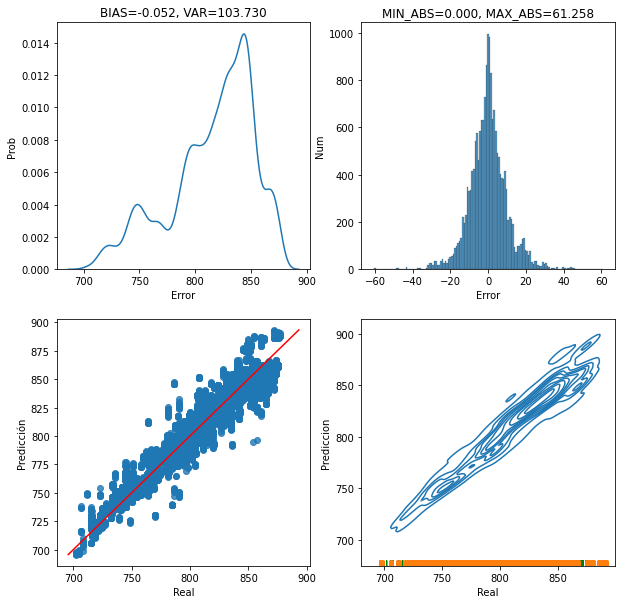

In [18]:
# Visualiza los errores de validación cruzada repetida 10 veces
num_bags = 10
y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


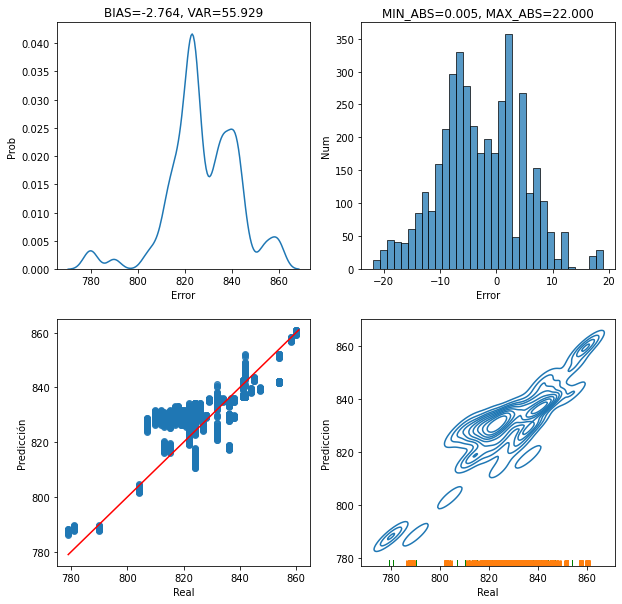

In [19]:
# Visualiza los errores de testeo \\\\ con alta varianza 
num_bags = 10
num_folds = 5
y_true_rep = np.array(list(y_test)*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = tst_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

**EJERCICIO: Interpreta las gráficas anteriores. ¿Para qué sirven? Si te fijas en los errores de validación, ¿Crees que el modelo subestima? Si es así, ¿Dónde? ¿Y sobreestima? Si es así, ¿Dónde?. Justifica tu respuesta**

La primera gráfica indica cada error la probabilidad de que suceda.
La segunda gráfica indica cada error cuantas veces ha sucedido.
La tercera gráfica indica el numero que da la prediccion frente al real.
La cuarta gráfica indica lo mismo que la anterior pero en lugar con puntos, con curbas de nivel (cuanos mas nivel mas densidad).

El modelo subestima más, para valores mayores a 820. En cambio para los valores menores de 820 y mayores que 800 vemos que sobrestima.

### Selección del Mejor Número de Folds

Aunque hemos elegido inicialmente 5 folds, surge la duda de si este número es la mejor elección. En el siguiente código ejecutamos el modelo con diferente número de folds para una sola repetición (num_bags=1) y visualizamos el sesgo (BIAS) y varianza de los errores obtenidos.

In [20]:
model = Ridge(alpha=1e-02)
for nfolds in np.arange(2,21):
    _, _, _, _, _, _, y_val, _, _, _, val_mat, tst_mat = entrena_model(model, num_folds=nfolds, num_bags=1)
    y_pred_val_mean = np.mean(val_mat,axis=1) # sacar un vector con todas las preds
    errores = y_val-y_pred_val_mean # Obtenemos los errores
    print('NFOLDS={} ERRORES [BIAS={:,.3f},VAR={:,.3f}]'.format(nfolds,np.mean(errores),np.var(errores)))

NFOLDS=2 ERRORES [BIAS=-0.193,VAR=107.430]
NFOLDS=3 ERRORES [BIAS=-0.119,VAR=103.818]
NFOLDS=4 ERRORES [BIAS=-0.077,VAR=104.748]
NFOLDS=5 ERRORES [BIAS=-0.023,VAR=101.225]
NFOLDS=6 ERRORES [BIAS=-0.061,VAR=105.235]
NFOLDS=7 ERRORES [BIAS=-0.046,VAR=102.579]
NFOLDS=8 ERRORES [BIAS=-0.077,VAR=104.402]
NFOLDS=9 ERRORES [BIAS=-0.047,VAR=102.298]
NFOLDS=10 ERRORES [BIAS=-0.017,VAR=102.494]
NFOLDS=11 ERRORES [BIAS=-0.050,VAR=102.785]
NFOLDS=12 ERRORES [BIAS=-0.026,VAR=102.890]
NFOLDS=13 ERRORES [BIAS=-0.025,VAR=102.639]
NFOLDS=14 ERRORES [BIAS=-0.024,VAR=102.438]
NFOLDS=15 ERRORES [BIAS=-0.034,VAR=102.746]
NFOLDS=16 ERRORES [BIAS=-0.029,VAR=102.587]
NFOLDS=17 ERRORES [BIAS=-0.036,VAR=102.747]
NFOLDS=18 ERRORES [BIAS=-0.025,VAR=103.137]
NFOLDS=19 ERRORES [BIAS=-0.030,VAR=102.709]
NFOLDS=20 ERRORES [BIAS=-0.029,VAR=103.252]


**RESPONDE A LAS SIGUIENTES CUESTIONES: ¿Cuál crees que es la mejor elección en este caso? ¿Por qué? Justifica tu respuesta.**

Con 5 folds o 10, pues tienen un BIAS bajo (mejor e 10) y una varianza bastante baja (mejor el 5 para varianza, por la proporcion me quedaria con 10 folds.

**RESPONDE A LAS SIGUIENTES CUESTIONES: Ejecuta el código anterior pero con *num_bags*=10. Compara los resultados con los obtenidos antes ¿Qué es lo que pasa? ¿Que *k* elegirías ahora? Justifica tu respuesta.**

In [21]:
model = Ridge(alpha=1e-02)
for nfolds in np.arange(2,21):
    _, _, _, _, _, _, y_val, _, _, _, val_mat, tst_mat = entrena_model(model, num_folds=nfolds, num_bags=10)
    y_pred_val_mean = np.mean(val_mat,axis=1) # sacar un vector con todas las preds
    errores = y_val-y_pred_val_mean # Obtenemos los errores
    print('NFOLDS={} ERRORES [BIAS={:,.3f},VAR={:,.3f}]'.format(nfolds,np.mean(errores),np.var(errores)))

NFOLDS=2 ERRORES [BIAS=-0.103,VAR=102.912]
NFOLDS=3 ERRORES [BIAS=-0.072,VAR=102.846]
NFOLDS=4 ERRORES [BIAS=-0.057,VAR=102.633]
NFOLDS=5 ERRORES [BIAS=-0.052,VAR=102.397]
NFOLDS=6 ERRORES [BIAS=-0.053,VAR=102.771]
NFOLDS=7 ERRORES [BIAS=-0.043,VAR=102.504]
NFOLDS=8 ERRORES [BIAS=-0.057,VAR=102.585]
NFOLDS=9 ERRORES [BIAS=-0.041,VAR=102.596]
NFOLDS=10 ERRORES [BIAS=-0.038,VAR=102.909]
NFOLDS=11 ERRORES [BIAS=-0.051,VAR=102.508]
NFOLDS=12 ERRORES [BIAS=-0.049,VAR=102.816]
NFOLDS=13 ERRORES [BIAS=-0.039,VAR=102.907]
NFOLDS=14 ERRORES [BIAS=-0.039,VAR=102.601]
NFOLDS=15 ERRORES [BIAS=-0.035,VAR=102.960]
NFOLDS=16 ERRORES [BIAS=-0.048,VAR=102.739]
NFOLDS=17 ERRORES [BIAS=-0.037,VAR=102.732]
NFOLDS=18 ERRORES [BIAS=-0.040,VAR=102.687]
NFOLDS=19 ERRORES [BIAS=-0.037,VAR=102.803]
NFOLDS=20 ERRORES [BIAS=-0.039,VAR=102.999]


Vemos que la varianza se ha estabilizado en 102 aunque haya valores cercanos a 103. Pero de cara al BIAS. Yo eligiría 10 porque cuantos menos folds para entrenar mejor, no merece la pena cambiarlo.

### Modelo Final Lineal de Ridge Regression

Buscamos de nuevo el mejor modelo con el valor de *k* que elija el estudiante.

In [22]:
from sklearn.linear_model import Ridge
k_elegido = 10 # CAMBIAR AL ELEGIDO POR EL ESTUDIANTE
# Probamos con diferentes potencias de 10
for alpha in np.power(10.0,np.arange(-2,3,0.3)):
    model = Ridge(alpha=alpha)
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('RIDGE con alpha={:.1e} ->\
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(alpha, 
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

RIDGE con alpha=1.0e-02 ->    Val:[MAE=7.338,RMSE=10.144,R2=0.927]     Test:[MAE=6.497,RMSE=7.920,R2=0.718]
RIDGE con alpha=2.0e-02 ->    Val:[MAE=7.338,RMSE=10.144,R2=0.927]     Test:[MAE=6.497,RMSE=7.920,R2=0.718]
RIDGE con alpha=4.0e-02 ->    Val:[MAE=7.338,RMSE=10.144,R2=0.927]     Test:[MAE=6.496,RMSE=7.919,R2=0.718]
RIDGE con alpha=7.9e-02 ->    Val:[MAE=7.338,RMSE=10.144,R2=0.927]     Test:[MAE=6.496,RMSE=7.919,R2=0.718]
RIDGE con alpha=1.6e-01 ->    Val:[MAE=7.338,RMSE=10.144,R2=0.927]     Test:[MAE=6.495,RMSE=7.917,R2=0.718]
RIDGE con alpha=3.2e-01 ->    Val:[MAE=7.338,RMSE=10.145,R2=0.927]     Test:[MAE=6.492,RMSE=7.915,R2=0.719]
RIDGE con alpha=6.3e-01 ->    Val:[MAE=7.338,RMSE=10.145,R2=0.927]     Test:[MAE=6.488,RMSE=7.910,R2=0.719]
RIDGE con alpha=1.3e+00 ->    Val:[MAE=7.339,RMSE=10.145,R2=0.927]     Test:[MAE=6.480,RMSE=7.900,R2=0.720]
RIDGE con alpha=2.5e+00 ->    Val:[MAE=7.340,RMSE=10.145,R2=0.927]     Test:[MAE=6.466,RMSE=7.882,R2=0.721]
RIDGE con alpha=5.0e+00 ->  

In [23]:
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_ridge, preds_test_ridge, val_mat, tst_mat = entrena_model(model=Ridge(1.0e-02), num_folds=k_elegido)
mae_ridge_tst = 6.497
rmse_ridge_tst = 7.920
rmse_ridge_val = 10.144
mae_ridge_val = 7.338


var_sup_25_ridge = np.mean(abs(preds_test_ridge - y_test_ridge))
print(var_sup_25_ridge)

6.496821510079791


**RESPONDE A LAS SIGUIENTE CUESTIÓN: ¿Por qué no elegimos el modelo que tiene el mejor RMSE de testeo?**

Porque el de testeo esta para 81 bobinas, es demasiado muy pequeño y depende demasiado de cuales haya escogido.

### Modelo K-NN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in range(8):
    model = KNeighborsClassifier(n_neighbors=n_neighbors+1) 
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('KNN con k={} vecinos -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(n_neighbors+1, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

KNN con k=1 vecinos ->     Val:[MAE=5.748,RMSE=10.843,R2=0.917]     Test:[MAE=10.560,RMSE=12.335,R2=0.317]
KNN con k=2 vecinos ->     Val:[MAE=6.202,RMSE=11.480,R2=0.907]     Test:[MAE=10.117,RMSE=12.325,R2=0.318]
KNN con k=3 vecinos ->     Val:[MAE=7.001,RMSE=13.180,R2=0.877]     Test:[MAE=10.214,RMSE=12.833,R2=0.260]
KNN con k=4 vecinos ->     Val:[MAE=7.219,RMSE=13.517,R2=0.871]     Test:[MAE=15.019,RMSE=18.936,R2=-0.611]
KNN con k=5 vecinos ->     Val:[MAE=7.403,RMSE=14.005,R2=0.861]     Test:[MAE=15.416,RMSE=20.483,R2=-0.885]
KNN con k=6 vecinos ->     Val:[MAE=7.595,RMSE=14.331,R2=0.855]     Test:[MAE=15.653,RMSE=20.679,R2=-0.921]
KNN con k=7 vecinos ->     Val:[MAE=7.771,RMSE=14.539,R2=0.851]     Test:[MAE=15.245,RMSE=20.201,R2=-0.833]
KNN con k=8 vecinos ->     Val:[MAE=8.001,RMSE=14.767,R2=0.846]     Test:[MAE=14.725,RMSE=19.790,R2=-0.759]


Analizando los resultados elegimos el modelo con k vecinos que **tenga menor RMSE de validación cruzada**.

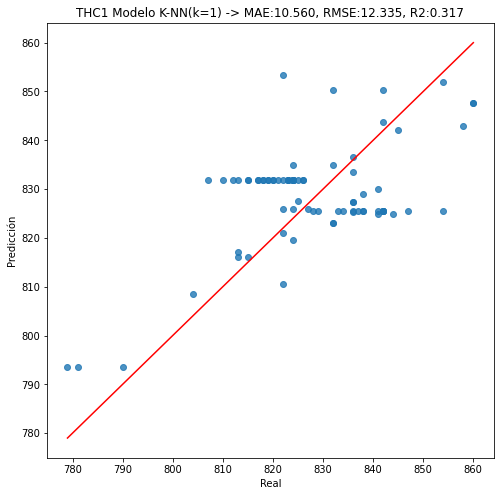

In [25]:
model = KNeighborsClassifier(n_neighbors=1) 
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_knn, preds_test_knn, val_mat, tst_mat = entrena_model(model, num_folds=k_elegido)
dibuja_preds(y_test, preds_test_knn, mae_tst, rmse_tst, r2_tst, 'THC1 Modelo K-NN(k=1) -> ')
mae_knn_tst = mae_tst
rmse_knn_tst=rmse_tst
rmse_knn_val = rmse_val
mae_knn_val = mae_val


In [26]:
var_sup_25_knn = np.mean(abs(preds_test_knn - y_test_knn))
print(var_sup_25_knn)


10.559753086419736


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


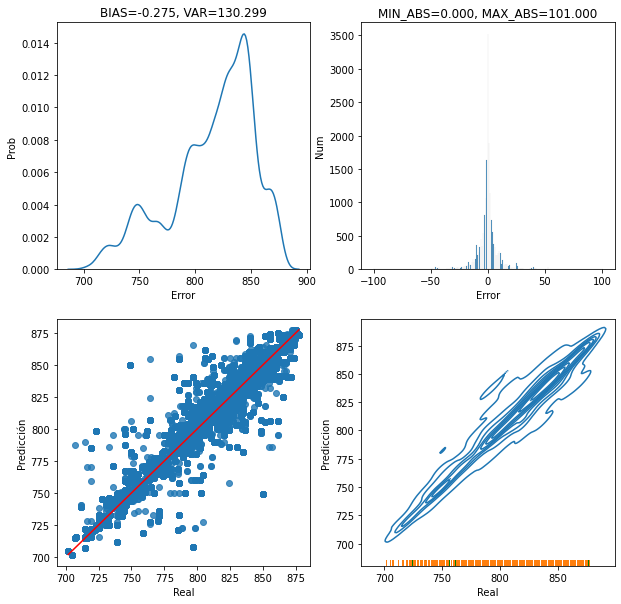

In [27]:
# Visualiza los errores de validación cruzada repetida 15 veces
num_bags = 10
y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


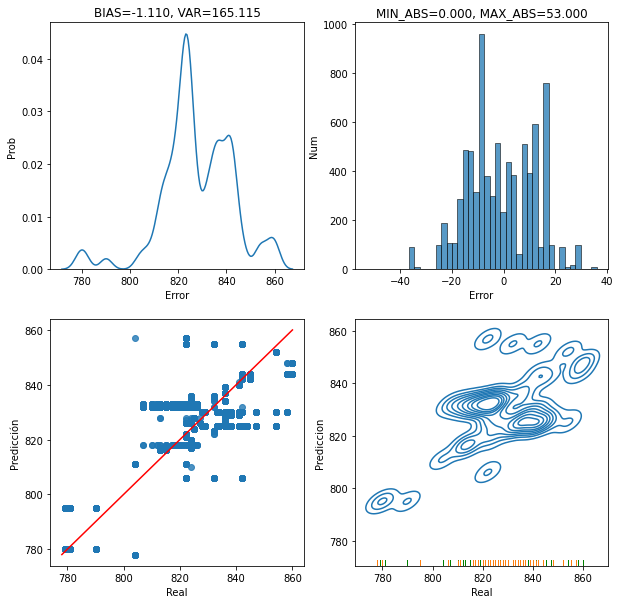

In [28]:
# Visualiza los errores de testeo
num_bags = 10
num_folds = k_elegido
y_true_rep = np.array(list(y_test)*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = tst_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

**RESPONDE A LA SIGUIENTES CUESTIÓN: KNN tiene un MAE de validación mejor que el modelo RIDGE aunque un RMSE de validación ligeramente peor. Sin embargo, los errores de testeo del KNN son mucho mayores que los del modelo RIDGE. ¿Por qué crees que pasa esto? Justifica tu respuesta.**

KNN tiene mejor validacion y peor testeo, porque para diferentes bobinas (datos diferentes a los del entrenamiento) funciona peor, y porque no ha sido entrenado para los nuevos.

### Modelo ANN

Vamos a usar modelo de redes neuronales para regresión. La función *MLPRegressor()* dispone de diferentes 'solvers' para el entrenamiento de la red neuronal. Habitualmente, el solver 'Adam' (y sus variantes) funciona bastante bien con bases de datos grandes. Para bases de datos pequeñas, el método 'lbfgs' puede converger más rápido y es mucho más fácil de entrenar.
MLPRegressor utiliza por defecto funciones de activación 'relu'.

Vamos a buscar el tamaño de red más adecuado considerando una sola capa oculta.

**OJO!: Todos los resultados siguientes pueden cambiar según el *k* fold elegido**

In [29]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPRegressor
for num_neuronas in np.arange(1,51,5):
    model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=1 ->     Val:[MAE=18.997,RMSE=49.305,R2=-0.718]     Test:[MAE=8.688,RMSE=12.577,R2=0.289]
ANN con num_neuronas=6 ->     Val:[MAE=8.584,RMSE=26.141,R2=0.517]     Test:[MAE=5.872,RMSE=7.251,R2=0.764]
ANN con num_neuronas=11 ->     Val:[MAE=8.027,RMSE=21.055,R2=0.687]     Test:[MAE=5.166,RMSE=6.431,R2=0.814]
ANN con num_neuronas=16 ->     Val:[MAE=7.193,RMSE=13.289,R2=0.875]     Test:[MAE=5.244,RMSE=6.565,R2=0.806]
ANN con num_neuronas=21 ->     Val:[MAE=6.929,RMSE=10.690,R2=0.919]     Test:[MAE=5.135,RMSE=6.478,R2=0.811]
ANN con num_neuronas=26 ->     Val:[MAE=6.913,RMSE=10.655,R2=0.920]     Test:[MAE=5.387,RMSE=6.828,R2=0.791]
ANN con num_neuronas=31 ->     Val:[MAE=7.038,RMSE=13.345,R2=0.874]     Test:[MAE=5.336,RMSE=6.789,R2=0.793]
ANN con num_neuronas=36 ->     Val:[MAE=7.079,RMSE=12.769,R2=0.885]     Test:[MAE=5.338,RMSE=6.725,R2=0.797]
ANN con num_neuronas=41 ->     Val:[MAE=7.224,RMSE=15.295,R2=0.835]     Test:[MAE=5.420,RMSE=6.868,R2=0.788]
ANN con num_neuron

Probamos a cambiar la función de activación por una sigmoidea (activation='logistic') pues suele funcionar bien y es más estable en bases de datos estandarizadas y con pocas variables.

In [30]:
from sklearn.neural_network import MLPRegressor
for num_neuronas in np.arange(1,51,5):
    model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs', activation='logistic')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=1 ->     Val:[MAE=22.741,RMSE=28.488,R2=0.427]     Test:[MAE=10.799,RMSE=13.882,R2=0.134]
ANN con num_neuronas=6 ->     Val:[MAE=8.906,RMSE=14.217,R2=0.857]     Test:[MAE=5.592,RMSE=6.884,R2=0.787]
ANN con num_neuronas=11 ->     Val:[MAE=5.907,RMSE=11.666,R2=0.904]     Test:[MAE=5.124,RMSE=6.301,R2=0.822]
ANN con num_neuronas=16 ->     Val:[MAE=5.290,RMSE=9.438,R2=0.937]     Test:[MAE=4.607,RMSE=6.123,R2=0.832]
ANN con num_neuronas=21 ->     Val:[MAE=5.320,RMSE=10.438,R2=0.923]     Test:[MAE=4.619,RMSE=6.405,R2=0.816]
ANN con num_neuronas=26 ->     Val:[MAE=5.423,RMSE=11.550,R2=0.906]     Test:[MAE=4.784,RMSE=6.575,R2=0.806]
ANN con num_neuronas=31 ->     Val:[MAE=5.364,RMSE=10.948,R2=0.915]     Test:[MAE=5.131,RMSE=6.878,R2=0.788]
ANN con num_neuronas=36 ->     Val:[MAE=5.481,RMSE=12.051,R2=0.897]     Test:[MAE=5.055,RMSE=6.877,R2=0.788]
ANN con num_neuronas=41 ->     Val:[MAE=5.562,RMSE=12.753,R2=0.885]     Test:[MAE=5.182,RMSE=6.993,R2=0.780]
ANN con num_neurona

Vemos que con funciones de activación sigmoidea el modelo con 16 neuronas obtiene el mejor RMSE de validación. Además, se observa que los modelos próximos, con 21 y 26 neuronas, son más estables con RMSE menores que los modelos con 'relu'.

Vamos a afinar un poco más la búsqueda.

In [31]:
# Afinamos en la búsqueda cerca de las 16 neuronas (menor RMSE de validación)
for num_neuronas in np.arange(12,21,1):
    model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs', activation='logistic')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=12 ->     Val:[MAE=5.529,RMSE=9.976,R2=0.930]     Test:[MAE=5.106,RMSE=6.317,R2=0.821]
ANN con num_neuronas=13 ->     Val:[MAE=5.531,RMSE=11.164,R2=0.912]     Test:[MAE=4.955,RMSE=6.173,R2=0.829]
ANN con num_neuronas=14 ->     Val:[MAE=5.410,RMSE=9.671,R2=0.934]     Test:[MAE=4.955,RMSE=6.268,R2=0.824]
ANN con num_neuronas=15 ->     Val:[MAE=5.301,RMSE=9.194,R2=0.940]     Test:[MAE=4.814,RMSE=6.198,R2=0.827]
ANN con num_neuronas=16 ->     Val:[MAE=5.290,RMSE=9.438,R2=0.937]     Test:[MAE=4.607,RMSE=6.123,R2=0.832]
ANN con num_neuronas=17 ->     Val:[MAE=5.428,RMSE=10.776,R2=0.918]     Test:[MAE=4.480,RMSE=6.033,R2=0.836]
ANN con num_neuronas=18 ->     Val:[MAE=5.309,RMSE=9.616,R2=0.935]     Test:[MAE=4.392,RMSE=5.949,R2=0.841]
ANN con num_neuronas=19 ->     Val:[MAE=5.408,RMSE=11.001,R2=0.914]     Test:[MAE=4.507,RMSE=6.190,R2=0.828]
ANN con num_neuronas=20 ->     Val:[MAE=5.316,RMSE=9.853,R2=0.931]     Test:[MAE=4.645,RMSE=6.318,R2=0.821]


Parece que con 16 neuronas seguimos teniendo el mejor RMSE y R2 de validación.

Vamos a intentar mejorar los resultados mediante *regularización* usando el párametro *alpha*. Este parámetro, usualmente denominado *L2 penaly* o *weight decay*, incluye en la función de pérdida (función *loss*), la suma del cuadrado de los pesos multiplicado por *alpha*, penalizando los modelos con pesos altos en el proceso de entrenamiento. Modelos con pesos más bajos son modelos más robustos, es decir, menos sensibles al ruido y los espurios. Para *alpha* probamos diferentes potencias de 10. También se podría probar con más o menos neuronas.

In [32]:
for num_neuronas in [16]:
    for alpha in np.power(10.0,np.arange(-7,3,1)):
        model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), alpha=alpha, solver='lbfgs', activation='logistic')
        mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
        print('ANN neuronas={} alpha={:,.1e} -> \
        Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
        Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, alpha,
                                                          mae_val, rmse_val, r2_val, 
                                                          mae_tst, rmse_tst, r2_tst))

ANN neuronas=16 alpha=1.0e-07 ->         Val:[MAE=5.294,RMSE=9.459,R2=0.937]         Test:[MAE=4.652,RMSE=6.153,R2=0.830]
ANN neuronas=16 alpha=1.0e-06 ->         Val:[MAE=5.298,RMSE=9.464,R2=0.937]         Test:[MAE=4.606,RMSE=6.116,R2=0.832]
ANN neuronas=16 alpha=1.0e-05 ->         Val:[MAE=5.302,RMSE=9.468,R2=0.937]         Test:[MAE=4.616,RMSE=6.130,R2=0.831]
ANN neuronas=16 alpha=1.0e-04 ->         Val:[MAE=5.290,RMSE=9.438,R2=0.937]         Test:[MAE=4.607,RMSE=6.123,R2=0.832]
ANN neuronas=16 alpha=1.0e-03 ->         Val:[MAE=5.306,RMSE=9.448,R2=0.937]         Test:[MAE=4.535,RMSE=6.073,R2=0.834]
ANN neuronas=16 alpha=1.0e-02 ->         Val:[MAE=5.289,RMSE=9.491,R2=0.936]         Test:[MAE=4.616,RMSE=6.123,R2=0.832]
ANN neuronas=16 alpha=1.0e-01 ->         Val:[MAE=5.299,RMSE=9.453,R2=0.937]         Test:[MAE=4.562,RMSE=6.108,R2=0.832]
ANN neuronas=16 alpha=1.0e+00 ->         Val:[MAE=5.306,RMSE=9.610,R2=0.935]         Test:[MAE=4.541,RMSE=6.077,R2=0.834]
ANN neuronas=16 alpha=1.

In [33]:
# En este caso, mejoramos un poco:
# ANN neuronas=17 alpha=1.0e-05
num_neuronas=16
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')
alpha = 1e-05
model = MLPRegressor(hidden_layer_sizes=(16,), alpha=alpha, solver='lbfgs', activation='logistic')
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_ann, preds_test_ann, val_mat, tst_mat = entrena_model(model, num_folds=k_elegido)
print('ANN neuronas={} alpha={:,.1e} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, alpha,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))
mae_ann_tst = mae_tst
rmse_ann_tst = rmse_tst
rmse_ann_val = rmse_val
mae_ann_val = mae_val


var_sup_25_ann = np.mean(abs(preds_test_ann - y_test_ann))
print(var_sup_25_ann)


ANN neuronas=16 alpha=1.0e-05 ->     Val:[MAE=5.302,RMSE=9.468,R2=0.937]     Test:[MAE=4.616,RMSE=6.130,R2=0.831]
4.616020735379786


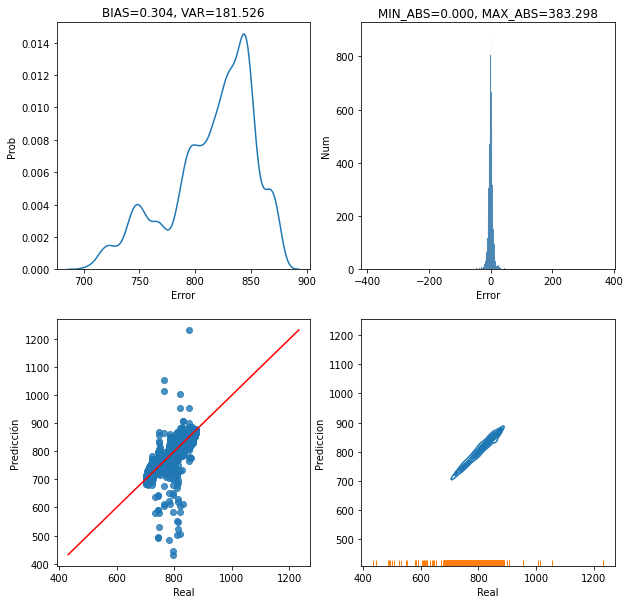

In [34]:
# Visualiza los errores de validación cruzada repetida
num_bags = 10
y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

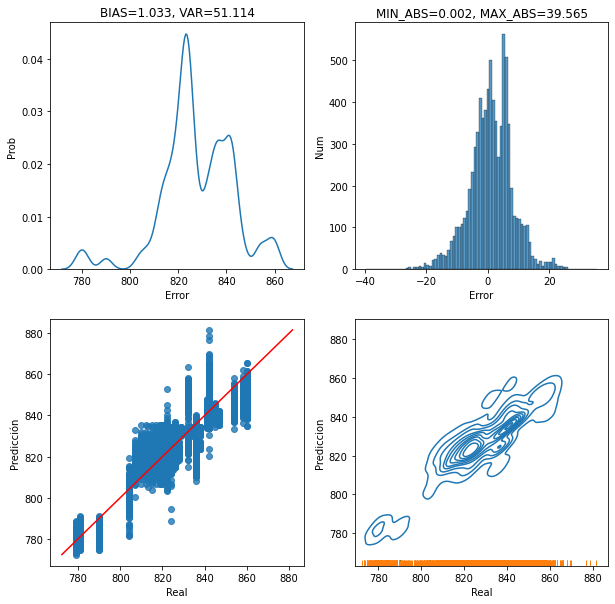

In [35]:
# Visualiza los errores de testeo
num_bags = 10
num_folds = k_elegido
y_true_rep = np.array(list(y_test)*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = tst_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

**EJERCICIO: Utilizando la metodología mostrada en las celdas anteriores buscar el mejor modelo SVR (sklearn.svm.SVR()) con kernel RBF y el mejor árbol de regresión (sklearn.tree.DecisionTreeRegressor()).**

In [36]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
num_bags = 10
num_folds=10

In [37]:
svr=SVR(kernel='rbf')
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_svr, preds_test_svr, val_mat, tst_mat = entrena_model(svr, num_folds=10)
y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds
print('Kernel={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format('rbf',
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))
#saca_predicciones(y_true_rep, y_pred_val_flatten)
print("RMSE validacion",rmse_val)
print("MAE validacion",mae_val)
print("RMSE testeo",rmse_tst)
print("MAE testeo",mae_tst)
mae_svr_tst=mae_tst
rmse_svr_tst=rmse_tst
rmse_svr_val = rmse_val
mae_svr_val = mae_val




RMSE validacion 19.831525915152643
MAE validacion 14.324783382984137
RMSE testeo 13.38577507301297
MAE testeo 11.504336873141856


In [38]:
var_sup_25_svr = np.mean(abs(preds_test_svr - y_test_svr))
print(var_sup_25_svr)

11.504336873141856


In [39]:
 regressor = DecisionTreeRegressor(random_state=0)
 entrena_model(regressor,10,10)
 mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_regressor, preds_test_regressor, val_mat, tst_mat = entrena_model(regressor, num_folds=k_elegido)
 y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
 y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds
 #saca_predicciones(y_true_rep, y_pred_val_flatten)
 rmse_regressor_tst = rmse_tst
 mae_regressor_tst = mae_tst
 rmse_regressor_val = rmse_val
 mae_regressor_val = mae_val

 var_sup_25_regressor = np.mean(abs(preds_test_regressor - y_test_regressor))
 print(var_sup_25_regressor)

 print("RMSE validacion",rmse_val)
 print("MAE validacion",mae_val)
 print("RMSE testeo",rmse_tst)
 print("MAE testeo",mae_tst)

6.213728660228656
RMSE validacion 7.998697453495711
MAE validacion 4.57141015186567
RMSE testeo 8.54943843901078
MAE testeo 6.213728660228656


**EJERCICIO: En una tabla incluye los errores MAE y RMSE de validación y testeo del mejor modelo de cada tipo. Así mismo, incluye el porcentaje de errores de testeo que han superado los 25 grados en valor absoluto. Compara los errores de testeo obtenidos con Python frente a los modelos obtenidos con WEKA en la práctica anterior.**

In [40]:
#mostramos la info, ademas asi lo tenemos almacenado en variables para cargarlo en el dataframe y hacer la tabla
print("RESULTADOS MODELO: RIDGE")
print("mae test:",mae_ridge_tst)
print("rmse test",rmse_ridge_tst)
print("mae val:",mae_ridge_val)
print("rmse val:",rmse_ridge_val)
print("rmse val:",rmse_ridge_val)
print("%>abs25:,",var_sup_25_ridge)
print("-----------------------------------------------------")
print("RESULTADOS MODELO: KNN")
print("mae:",mae_knn_tst)
print("rmse",rmse_knn_tst)
print("mae val:",mae_knn_val)
print("rmse val:",rmse_knn_val)
print("%>abs25:",var_sup_25_knn)
print("-----------------------------------------------------")
print("RESULTADOS MODELO: TREE REGRESSOR")
print("mae:",mae_regressor_tst)
print("rmse",rmse_regressor_tst)
print("mae val:",mae_regressor_val)
print("rmse val:",rmse_regressor_val)
print("%>abs25:",var_sup_25_regressor)
print("-----------------------------------------------------")
print("RESULTADOS MODELO: ANN")
print("mae:",mae_ann_tst)
print("rmse",rmse_ann_tst)
print("mae val:",mae_ann_val)
print("rmse val:",rmse_ann_val)
print("%>abs25:",var_sup_25_ann)
print("-----------------------------------------------------")
print("RESULTADOS MODELO: SVR")
print("mae:",mae_svr_tst)
print("rmse:",rmse_svr_tst)
print("mae val:",mae_svr_val)
print("rmse val:",rmse_svr_val)
print("%>abs25:",var_sup_25_svr)
print("===============WEKA============================")
print("RESULTADOS MODELO: Regre. Lineal")
print("mae: 8.4027")
print("rmse: 11.4753")
print("mae val: 4.6784")
print("rmse val: 6.1578")
print("-----------------------------------------------------")
print("RESULTADOS MODELO: MLSPRegression")
print("mae: 4.2888")
print("rmse 7.4601")
print("mae val: 3.2448")
print("rmse val: 4.2811")
print("-----------------------------------------------------")
print("RESULTADOS MODELO: Ibk")
print("mae: 4.7483")
print("rmse: 8.672")
print("mae val: 4.2968")
print("rmse val: 7.4201")
print("-----------------------------------------------------")
print("RESULTADOS MODELO: M5P")
print("mae: 4.6898")
print("rmse: 7.3104")
print("mae val: 3.8325")
print("rmse val: 5.4874")

RESULTADOS MODELO: RIDGE
mae test: 6.497
rmse test 7.92
mae val: 7.338
rmse val: 10.144
rmse val: 10.144
%>abs25:, 6.496821510079791
-----------------------------------------------------
RESULTADOS MODELO: KNN
mae: 10.559753086419736
rmse 12.334848155220445
mae val: 5.74813614262561
rmse val: 10.843447632742064
%>abs25: 10.559753086419736
-----------------------------------------------------
RESULTADOS MODELO: TREE REGRESSOR
mae: 6.213728660228656
rmse 8.54943843901078
mae val: 4.57141015186567
rmse val: 7.998697453495711
%>abs25: 6.213728660228656
-----------------------------------------------------
RESULTADOS MODELO: ANN
mae: 4.616020735379786
rmse 6.129962764030615
mae val: 5.30151076436282
rmse val: 9.467900902619547
%>abs25: 4.616020735379786
-----------------------------------------------------
RESULTADOS MODELO: SVR
mae: 11.504336873141856
rmse: 13.38577507301297
mae val: 14.324783382984137
rmse val: 19.831525915152643
%>abs25: 11.504336873141856
===============WEKA============

**CUESTIONES: ¿Qué modelo elegirías finalmente? Justifica tu respuesta.**

Elegiría, a priori, el tree Regressor de testeo tampoco podemos fiarnos al haber muy pocos, pero en cuestion a coste computacional y resultados, da muy buen resultado, reñido con el ANN, es el que mejor resultados saca sin lugar a dudas. 
Pero viendo como se comporta el regressor tree para nuevos elementos, mejor cambio o a SVR que aunque salga peor se comporta bien o al ANN.

**EJERCICIO FINAL: ¿Te sientes capaz de mejorar los resultados añadiendo nuevas características (features) o probando otras técnicas?**

A continuación una mejora del arbol de regression simplemente añadiendo el min_samples_split y modificando las hojas..

Tambien podemos pasar de criterion="mse" (el por defecto) que es en si el criterio del split.
He aqui unas mejopras sustanciales del modelo del arbol.
Vemos que funciona mejor con 1 ó 2 hojas, no más. Y los mejores resultados con split 2 ó 4 y 2 hojas.

In [41]:
 for i in (2,4,6,8,10):
   print("--------------------------------")
   print("--------------------------------")
   print("split:",i)
   for j in (1,2,4,6,8,10):
      regressor = DecisionTreeRegressor(random_state=2020,min_samples_split=i,criterion="friedman_mse",splitter="random",min_samples_leaf=j)
      mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_regressor, preds_test_regressor, val_mat, tst_mat = entrena_model(regressor, num_folds=k_elegido)
      print('DTR con criterion={}, splitter={}- \
      Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
      Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, alpha,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))


--------------------------------
--------------------------------
split: 2
DTR con criterion=16, splitter=1e-05-      Val:[MAE=4.316,RMSE=7.426,R2=0.961]      Test:[MAE=5.732,RMSE=7.910,R2=0.719]
DTR con criterion=16, splitter=1e-05-      Val:[MAE=4.401,RMSE=7.018,R2=0.965]      Test:[MAE=5.778,RMSE=7.531,R2=0.745]
DTR con criterion=16, splitter=1e-05-      Val:[MAE=5.075,RMSE=7.828,R2=0.957]      Test:[MAE=6.288,RMSE=7.857,R2=0.723]
DTR con criterion=16, splitter=1e-05-      Val:[MAE=5.612,RMSE=8.583,R2=0.948]      Test:[MAE=7.008,RMSE=8.600,R2=0.668]
DTR con criterion=16, splitter=1e-05-      Val:[MAE=6.072,RMSE=9.155,R2=0.941]      Test:[MAE=7.623,RMSE=9.122,R2=0.626]
DTR con criterion=16, splitter=1e-05-      Val:[MAE=6.473,RMSE=9.524,R2=0.936]      Test:[MAE=7.181,RMSE=8.717,R2=0.659]
--------------------------------
--------------------------------
split: 4
DTR con criterion=16, splitter=1e-05-      Val:[MAE=4.309,RMSE=7.333,R2=0.962]      Test:[MAE=5.721,RMSE=7.575,R2=0.742]
DTR

Sale muy bien con min_samples_split=2 y min_shanples_leaf=2

In [42]:
for i in (100,300,1000):
  svr=SVR(kernel='rbf',C=i)
  mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test_svr, preds_test_svr, val_mat, tst_mat = entrena_model(svr, num_folds=10)
  y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
  y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds

  print("C = ",i)
  print("RMSE validacion",rmse_val)
  print("MAE validacion",mae_val)
  
  print("----------------------------")


C =  100
RMSE validacion 9.784342277333348
MAE validacion 5.879189914543142
----------------------------
C =  300
RMSE validacion 9.213950952212675
MAE validacion 5.539940953747233
----------------------------
C =  1000
RMSE validacion 8.746145766766762
MAE validacion 5.2588374778607365
----------------------------


Vemos que el svr con una alta C da muy buen resultado.

# ENTREGA

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.